# Import Data and Preprocessing

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"applejin","key":"0b93924b947f72a219bb11234c07cc77"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.75G/3.75G [01:36<00:00, 40.3MB/s]
100% 3.75G/3.75G [01:36<00:00, 41.9MB/s]


In [ ]:
!unzip 140k-real-and-fake-faces.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_vs_fake/real-vs-fake/vali

In [ ]:
import os
import glob
import pandas as pd

main_path = './real_vs_fake/real-vs-fake'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

images_df = {
    "folder":[],
    "image_path":[],
    "label":[]
}

for folder in os.listdir(main_path): #iterate on each train, valid and test folder
    for label in os.listdir(main_path + "/" + folder): #iterate on fake and real folders (labels)
        for img in glob.glob(main_path + "/" + folder + "/" + label + "/*.jpg"):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)
images_df = pd.DataFrame(images_df)
images_df

,folder,image_path,label
0,test,./real_vs_fake/real-vs-fake/test/fake/X7OYS6J8...,fake
1,test,./real_vs_fake/real-vs-fake/test/fake/NTPNG1NS...,fake
2,test,./real_vs_fake/real-vs-fake/test/fake/V3YM4RT6...,fake
3,test,./real_vs_fake/real-vs-fake/test/fake/68D9KPTJ...,fake
4,test,./real_vs_fake/real-vs-fake/test/fake/UXKW0DSP...,fake
...,...,...,...
139995,valid,./real_vs_fake/real-vs-fake/valid/real/16113.jpg,real
139996,valid,./real_vs_fake/real-vs-fake/valid/real/37598.jpg,real
139997,valid,./real_vs_fake/real-vs-fake/valid/real/15864.jpg,real
139998,valid,./real_vs_fake/real-vs-fake/valid/real/49552.jpg,real


In [ ]:
real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "fake"].groupby('folder')

import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import seaborn as sns
from sklearn import metrics

image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  horizontal_flip=True,
                                  )

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [ ]:
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False) #shuffle disabled

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [ ]:
input_shape = (256, 256, 3)

# Load the saved best weights

In [ ]:
files.upload()

Saving model_best_weights（基础）.h5 to model_best_weights（基础）.h5


In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

base_model.trainable = False

for layer in base_model.layers[-10:]: # unfreeze the last 10 layers
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

# from tensorflow.keras.layers import Dropout
# x = Dropout(0.5)(x)  # add a dropout layer
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), # lower the learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

17225924/17225924 [==============================] - 1s 0us/step


In [ ]:
files.upload()

Saving model_best_weights.h5 to model_best_weights.h5


In [ ]:
model.load_weights(filepath='model_best_weights.h5')
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

313/313 [==============================] - 53s 156ms/step - loss: 0.1416 - accuracy: 0.9413
Test Loss: 0.14161750674247742, Test Accuracy: 0.941349983215332


In [ ]:
predicted_label = model.predict(test_ds)

313/313 [==============================] - 49s 155ms/step


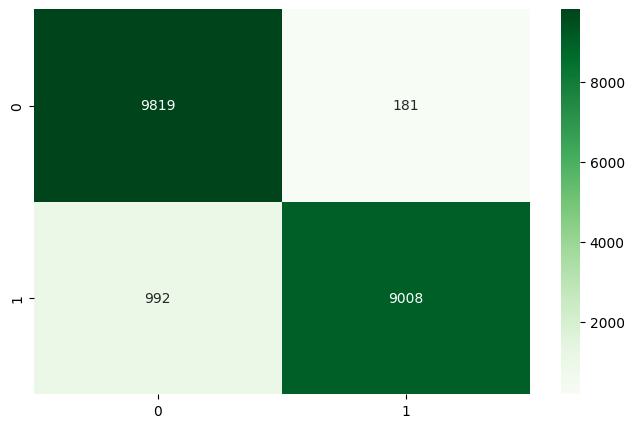

In [ ]:
true_label = test_ds.classes
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_label, predicted_label.round()), annot = True,fmt="d",cmap = "Greens")
plt.show()

In [ ]:
metrics.accuracy_score(true_label, predicted_label.round())

0.94135

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming true_labels and predicted_labels are your true and predicted labels respectively
predicted_labels_rounded = predicted_label.round()  # Ensure predicted labels are rounded to 0 or 1

precision = precision_score(true_label, predicted_labels_rounded)
recall = recall_score(true_label, predicted_labels_rounded)
f1 = f1_score(true_label, predicted_labels_rounded)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.9803025356404397
Recall: 0.9008
F1 Score: 0.9388712283078847


# Test on Stable Diffusion images

  Fake images used here are collected [here](https://www.kaggle.com/datasets/bwandowando/faces-dataset-using-stable-diffusion-v14).
  
  We manually combined it with some real images that you can find it [here](https://www.kaggle.com/datasets/atulanandjha/lfwpeople/data)

In [ ]:
files.upload()

Saving 500_Stable Diffusion_Face copy.zip to 500_Stable Diffusion_Face copy.zip


In [ ]:
!unzip "500_Stable Diffusion_Face copy.zip"

Archive:  500_Stable Diffusion_Face copy.zip
   creating: 500_Stable Diffusion_Face copy/
  inflating: __MACOSX/._500_Stable Diffusion_Face copy  
  inflating: 500_Stable Diffusion_Face copy/.DS_Store  
  inflating: __MACOSX/500_Stable Diffusion_Face copy/._.DS_Store  
   creating: 500_Stable Diffusion_Face copy/real/
   creating: 500_Stable Diffusion_Face copy/fake/
  inflating: 500_Stable Diffusion_Face copy/real/Arnold_Schwarzenegger_0019.jpg  
  inflating: __MACOSX/500_Stable Diffusion_Face copy/real/._Arnold_Schwarzenegger_0019.jpg  
  inflating: 500_Stable Diffusion_Face copy/real/Ann_Veneman_0005.jpg  
  inflating: __MACOSX/500_Stable Diffusion_Face copy/real/._Ann_Veneman_0005.jpg  
  inflating: 500_Stable Diffusion_Face copy/real/Bill_Frist_0008.jpg  
  inflating: __MACOSX/500_Stable Diffusion_Face copy/real/._Bill_Frist_0008.jpg  
  inflating: 500_Stable Diffusion_Face copy/real/Carla_Del_Ponte_0001.jpg  
  inflating: __MACOSX/500_Stable Diffusion_Face copy/real/._Carla_Del_P

In [ ]:
sd500_dir = './500_Stable Diffusion_Face copy'

images_df = {
    "image_path": [],
    "label": []
}

for label in os.listdir(sd500_dir):  # iterate on fake and real folders (labels)
    if label == "fake":
        img_format = "*.png"
    elif label == "real":
        img_format = "*.jpg"
    else:
        continue  # Skip any folder that is not 'fake' or 'real'

    for img in glob.glob(os.path.join(sd500_dir, label, img_format)):
        images_df["image_path"].append(img)
        images_df["label"].append(label)

images_df = pd.DataFrame(images_df)
print(images_df)


                                            image_path label
0    ./500_Stable Diffusion_Face copy/fake/seed_263...  fake
1    ./500_Stable Diffusion_Face copy/fake/seed_970...  fake
2    ./500_Stable Diffusion_Face copy/fake/seed_970...  fake
3    ./500_Stable Diffusion_Face copy/fake/seed_263...  fake
4    ./500_Stable Diffusion_Face copy/fake/seed_263...  fake
..                                                 ...   ...
495  ./500_Stable Diffusion_Face copy/real/Amanda_B...  real
496  ./500_Stable Diffusion_Face copy/real/Aleksand...  real
497  ./500_Stable Diffusion_Face copy/real/Alejandr...  real
498  ./500_Stable Diffusion_Face copy/real/Bob_Hope...  real
499  ./500_Stable Diffusion_Face copy/real/Barbara_...  real

[500 rows x 2 columns]


In [ ]:
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  horizontal_flip=True,
                                  )

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [ ]:
test_ds = image_gen.flow_from_directory(
    sd500_dir,
    target_size=(256, 256),
    class_mode='binary',
    shuffle=False) #shuffle disabled

Found 500 images belonging to 2 classes.


In [ ]:
model.load_weights(filepath='model_best_weights.h5')
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

16/16 [==============================] - 3s 194ms/step - loss: 2.6915 - accuracy: 0.5160
Test Loss: 2.691464424133301, Test Accuracy: 0.515999972820282


16/16 [==============================] - 3s 175ms/step


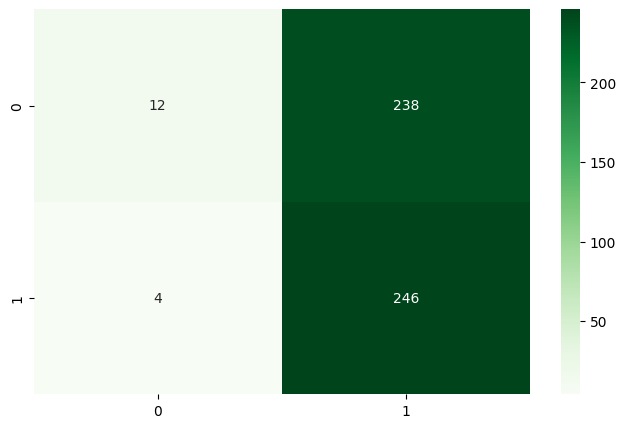

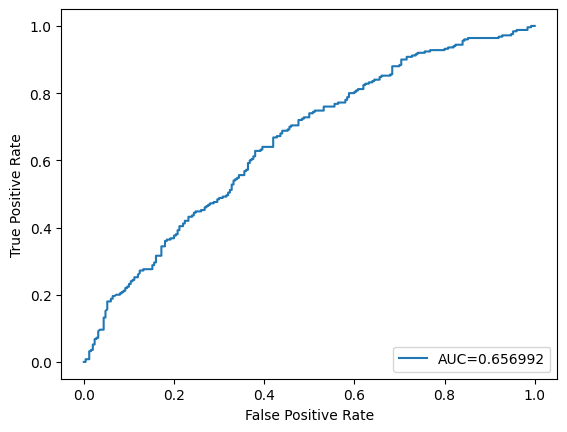

Precision: 0.5082644628099173
Recall: 0.984
F1 Score: 0.670299727520436


In [ ]:
predicted_labels = model.predict(test_ds)
true_labels = test_ds.classes
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels.round()), annot = True,fmt="d",cmap = "Greens")
plt.show()
metrics.accuracy_score(true_labels, predicted_labels.round())
fpr, tpr, _ = metrics.roc_curve(true_labels,  predicted_labels)
auc = metrics.roc_auc_score(true_labels, predicted_labels)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Assuming true_labels and predicted_labels are your true and predicted labels respectively
predicted_labels_rounded = predicted_labels.round()  # Ensure predicted labels are rounded to 0 or 1

precision = precision_score(true_labels, predicted_labels_rounded)
recall = recall_score(true_labels, predicted_labels_rounded)
f1 = f1_score(true_labels, predicted_labels_rounded)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Test the model using Stable Diffusion images


This is the data we used to do dataset augmentation later on. You can find the dataset [here](https://github.com/tobecwb/stable-diffusion-face-dataset.git).

In [ ]:
!git clone https://github.com/tobecwb/stable-diffusion-face-dataset.git

Cloning into 'stable-diffusion-face-dataset'...
remote: Enumerating objects: 9040, done.
remote: Counting objects: 100% (3024/3024), done.
remote: Compressing objects: 100% (3017/3017), done.
remote: Total 9040 (delta 7), reused 3021 (delta 4), pack-reused 6016
Receiving objects: 100% (9040/9040), 3.02 GiB | 25.06 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Updating files: 100% (9005/9005), done.


In [ ]:
import os
import shutil

# Base directory of the cloned dataset
base_dir = 'stable-diffusion-face-dataset'

# New base directory for the test set
new_base_dir = 'sd(1.5,2.1,xl1.0)_test_only'
os.makedirs(new_base_dir, exist_ok=True)

sizes = ['512', '768', '1024']

for size in sizes:
    # Create directory for each size in the test folder
    test_dir = os.path.join(new_base_dir, 'test', 'fake')
    os.makedirs(test_dir, exist_ok=True)

    # Process man and woman separately for each size
    for gender in ['man', 'woman']:
        # List all files in the current gender folder for each size
        files = os.listdir(os.path.join(base_dir, size, gender))
        # Sort the files to ensure consistent order (optional but recommended)
        files.sort()
        # Select the first 100 files
        selected_files = files[:100]

        # Move the selected files to the test directory
        for file in selected_files:
            original_path = os.path.join(base_dir, size, gender, file)
            new_path = os.path.join(test_dir, size + '_' + gender + '_' + os.path.basename(file))
            shutil.copy(original_path, new_path)

print("Test dataset setup complete.")


Test dataset setup complete.


In [ ]:
from google.colab import files
files.upload()

Saving testing_real.zip to testing_real.zip


In [ ]:
!unzip testing_real.zip

Archive:  testing_real.zip
   creating: training_real/
  inflating: __MACOSX/._training_real  
  inflating: training_real/real_00251.jpg  
  inflating: __MACOSX/training_real/._real_00251.jpg  
  inflating: training_real/real_00537.jpg  
  inflating: __MACOSX/training_real/._real_00537.jpg  
  inflating: training_real/real_00523.jpg  
  inflating: __MACOSX/training_real/._real_00523.jpg  
  inflating: training_real/real_00245.jpg  
  inflating: __MACOSX/training_real/._real_00245.jpg  
  inflating: training_real/real_00279.jpg  
  inflating: __MACOSX/training_real/._real_00279.jpg  
  inflating: training_real/real_00292.jpg  
  inflating: __MACOSX/training_real/._real_00292.jpg  
  inflating: training_real/real_00286.jpg  
  inflating: __MACOSX/training_real/._real_00286.jpg  
  inflating: training_real/real_00735.jpg  
  inflating: __MACOSX/training_real/._real_00735.jpg  
  inflating: training_real/real_00053.jpg  
  inflating: __MACOSX/training_real/._real_00053.jpg  
  inflating: t

In [ ]:
import os
import shutil

# Source directory containing the images
source_dir = 'testing_real'

# Target directory where the images will be moved
target_dir = 'sd(1.5,2.1,xl1.0)_test_only/test/real'
os.makedirs(target_dir, exist_ok=True)

# List all files in the source directory
files = os.listdir(source_dir)
# Sort the files to ensure consistent order (optional but recommended)
files.sort()
# Select the first 600 files
selected_files = files[:600]

# Move the selected files to the target directory
for file in selected_files:
    original_path = os.path.join(source_dir, file)
    new_path = os.path.join(target_dir, file)
    shutil.copy(original_path, new_path)

print("600 images have been moved to the test/real directory.")


600 images have been moved to the test/real directory.


In [ ]:
import glob
import pandas as pd
sd3_dir = './sd(1.5,2.1,xl1.0)_test_only/test'
images_df = {
    "image_path":[],
    "label":[]
}

for label in os.listdir(sd3_dir): #iterate on fake and real folders (labels)
    for img in glob.glob(sd3_dir + "/" + label + "/*.jpg"):
        images_df["image_path"].append(img)
        images_df["label"].append(label)
images_df = pd.DataFrame(images_df)
images_df

,image_path,label
0,"./sd(1.5,2.1,xl1.0)_test_only/test/fake/512_wo...",fake
1,"./sd(1.5,2.1,xl1.0)_test_only/test/fake/1024_w...",fake
2,"./sd(1.5,2.1,xl1.0)_test_only/test/fake/1024_m...",fake
3,"./sd(1.5,2.1,xl1.0)_test_only/test/fake/768_ma...",fake
4,"./sd(1.5,2.1,xl1.0)_test_only/test/fake/512_ma...",fake
...,...,...
1195,"./sd(1.5,2.1,xl1.0)_test_only/test/real/real_0...",real
1196,"./sd(1.5,2.1,xl1.0)_test_only/test/real/real_0...",real
1197,"./sd(1.5,2.1,xl1.0)_test_only/test/real/real_0...",real
1198,"./sd(1.5,2.1,xl1.0)_test_only/test/real/real_0...",real


In [ ]:
import tensorflow as tf  # Import TensorFlow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  horizontal_flip=True,
                                  )

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
test_ds = image_gen.flow_from_directory(
    sd3_dir,
    target_size=(256, 256),
    class_mode='binary',
    shuffle=False) #shuffle disabled

Found 1200 images belonging to 2 classes.


In [ ]:
from google.colab import files
files.upload()

Saving model_best_weights（基础）.h5 to model_best_weights（基础）.h5


In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

base_model.trainable = False

for layer in base_model.layers[-10:]: # unfreeze the last 10 layers
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

# from tensorflow.keras.layers import Dropout
# x = Dropout(0.5)(x)  # add a dropout layer
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), # lower the learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

17225924/17225924 [==============================] - 1s 0us/step


In [ ]:
model.load_weights(filepath='model_best_weights.h5')
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

38/38 [==============================] - 17s 346ms/step - loss: 2.8554 - accuracy: 0.4875
Test Loss: 2.8553640842437744, Test Accuracy: 0.48750001192092896


In [ ]:
import os
import shutil
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# Base test directory
test_dir = 'sd(1.5,2.1,xl1.0)_test_only/test'

# Define prefixes and their corresponding labels
prefixes = ['real', '512', '768', '1024']
labels = ['GAN', 'SD1.5', 'SD2.1', 'SDXL1.0']

# Function to filter images based on prefix
def load_images_for_prefix(prefix, label):
    # Temporary directory to hold filtered images
    temp_dir = 'temp_test_folder'
    os.makedirs(temp_dir, exist_ok=True)

    # Loop through 'fake' and 'real' directories
    for subdir in ['fake', 'real']:
        source_dir = os.path.join(test_dir, subdir)
        dest_dir = os.path.join(temp_dir, subdir)
        os.makedirs(dest_dir, exist_ok=True)

        # Copy images with the specific prefix
        for filename in os.listdir(source_dir):
            if filename.startswith(prefix):
                shutil.copy(os.path.join(source_dir, filename), dest_dir)

    # Load these images using ImageDataGenerator
    image_gen = ImageDataGenerator(rescale=1./255.)
    data_generator = image_gen.flow_from_directory(
        temp_dir,
        target_size=(256, 256),
        batch_size=64,
        class_mode='binary',
        shuffle=False)

    # Evaluate the model on this dataset
    loss, accuracy = model.evaluate(data_generator)
    print(f"Test accuracy for {label}: {accuracy}, Test loss: {loss}")

    # Cleanup the temporary directory
    shutil.rmtree(temp_dir)

# Loop over each generator prefix and test
for prefix, label in zip(prefixes, labels):
    load_images_for_prefix(prefix, label)


Found 600 images belonging to 2 classes.
10/10 [==============================] - 5s 468ms/step - loss: 0.1129 - accuracy: 0.9550
Test accuracy for GAN: 0.9549999833106995, Test loss: 0.11288972198963165
Found 200 images belonging to 2 classes.
4/4 [==============================] - 2s 452ms/step - loss: 6.1768 - accuracy: 0.0150
Test accuracy for SD1.5: 0.014999999664723873, Test loss: 6.176849842071533
Found 200 images belonging to 2 classes.
4/4 [==============================] - 4s 828ms/step - loss: 5.3489 - accuracy: 0.0150
Test accuracy for SD2.1: 0.014999999664723873, Test loss: 5.348884105682373
Found 200 images belonging to 2 classes.
4/4 [==============================] - 6s 1s/step - loss: 5.2678 - accuracy: 0.0300
Test accuracy for SDXL1.0: 0.029999999329447746, Test loss: 5.2677812576293945


# Test on GAN images

The Dataset we use here you can find [here](https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection).

In [ ]:
files.upload()

In [ ]:
!unzip GAN.zip

Archive:  GAN.zip
   creating: GAN/
  inflating: __MACOSX/._GAN          
  inflating: GAN/.DS_Store           
  inflating: __MACOSX/GAN/._.DS_Store  
   creating: GAN/real/
  inflating: __MACOSX/GAN/._real     
   creating: GAN/fake/
  inflating: __MACOSX/GAN/._fake     
  inflating: GAN/real/real_00251.jpg  
  inflating: __MACOSX/GAN/real/._real_00251.jpg  
  inflating: GAN/real/real_00537.jpg  
  inflating: __MACOSX/GAN/real/._real_00537.jpg  
  inflating: GAN/real/real_00523.jpg  
  inflating: __MACOSX/GAN/real/._real_00523.jpg  
  inflating: GAN/real/real_00245.jpg  
  inflating: __MACOSX/GAN/real/._real_00245.jpg  
  inflating: GAN/real/real_00279.jpg  
  inflating: __MACOSX/GAN/real/._real_00279.jpg  
  inflating: GAN/real/real_00292.jpg  
  inflating: __MACOSX/GAN/real/._real_00292.jpg  
  inflating: GAN/real/real_00286.jpg  
  inflating: __MACOSX/GAN/real/._real_00286.jpg  
  inflating: GAN/real/real_00735.jpg  
  inflating: __MACOSX/GAN/real/._real_00735.jpg  
  inflating: G

In [ ]:
gan_dir = './GAN'

images_df = {
    "image_path":[],
    "label":[]
}

for label in os.listdir(gan_dir): #iterate on fake and real folders (labels)
    for img in glob.glob(gan_dir + "/" + label + "/*.jpg"):
        images_df["image_path"].append(img)
        images_df["label"].append(label)
images_df = pd.DataFrame(images_df)
images_df

,image_path,label
0,./GAN/fake/easy_115_0010.jpg,fake
1,./GAN/fake/mid_468_1110.jpg,fake
2,./GAN/fake/mid_460_1111.jpg,fake
3,./GAN/fake/easy_204_0101.jpg,fake
4,./GAN/fake/hard_184_0011.jpg,fake
...,...,...
2036,./GAN/real/real_00730.jpg,real
2037,./GAN/real/real_00917.jpg,real
2038,./GAN/real/real_00614.jpg,real
2039,./GAN/real/real_00481.jpg,real


In [ ]:
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  horizontal_flip=True,
                                  )

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [ ]:
test_ds = image_gen.flow_from_directory(
    gan_dir,
    target_size=(256, 256),
    class_mode='binary',
    shuffle=False) #shuffle disabled

Found 2041 images belonging to 2 classes.


In [ ]:
files.upload()

Saving model_best_weights2.h5 to model_best_weights2.h5


In [ ]:
model.load_weights(filepath='model_best_weights2.h5')
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

64/64 [==============================] - 19s 297ms/step - loss: 2.3213 - accuracy: 0.5326
Test Loss: 2.321274995803833, Test Accuracy: 0.5325820446014404


64/64 [==============================] - 18s 276ms/step


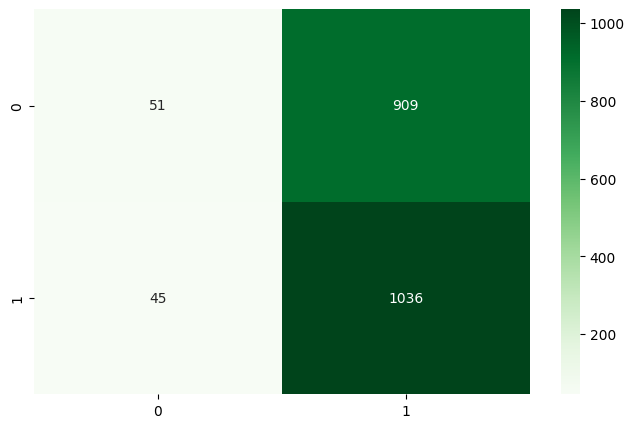

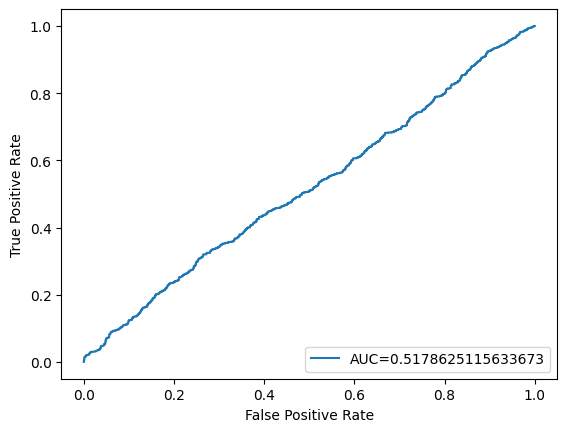

Precision: 0.5326478149100257
Recall: 0.9583718778908418
F1 Score: 0.6847323198942498


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

predicted_labels = model.predict(test_ds)
true_labels = test_ds.classes
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels.round()), annot = True,fmt="d",cmap = "Greens")
plt.show()
metrics.accuracy_score(true_labels, predicted_labels.round())
fpr, tpr, _ = metrics.roc_curve(true_labels,  predicted_labels)
auc = metrics.roc_auc_score(true_labels, predicted_labels)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Assuming true_labels and predicted_labels are your true and predicted labels respectively
predicted_labels_rounded = predicted_labels.round()  # Ensure predicted labels are rounded to 0 or 1

precision = precision_score(true_labels, predicted_labels_rounded)
recall = recall_score(true_labels, predicted_labels_rounded)
f1 = f1_score(true_labels, predicted_labels_rounded)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")